In [25]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Development

## Data Processing

### Feature Selection
**Selected Features**:

time_ind:	Simulation time index (used to extract hour features) \
transac_type:	Encoded transaction type (e.g., CASH_OUT = 0, TRANSFER = 1), only CASH_OUT and TRANSFER type is considered. \
amount:	Transaction amount, as we have seen a difference in distribution between fraud and genuine transactions. \
src_bal:	Sender's balance before transaction \
src_new_bal:	Sender's balance after transaction \
dst_bal:	Receiver's balance before transaction \
dst_new_bal:	Receiver's balance after transaction \
All balances have a tendency to be close to 0 when the transaction is fraudulent. \
hour_of_day:	Derived from time_ind % 24, genuine transaction has a period of day where transactions most often occur unlike fradulent transactions that happen uniformly at all periods. 

**Dropped features** :

src_acc, dst_acc: ID-like features are not useful. \
is_flagged_fraud: Excluded due to minimal relationship with target feature as seen in EDA.

In [2]:
df = pd.read_csv("../data/fraud_mock.csv")
processed_df = df.copy()

In [3]:
#exclude irrelevant columns: is_flagged_fraud, src_acc, dst_acc
processed_df.drop(columns=['is_flagged_fraud', 'src_acc', 'dst_acc'], axis=1, inplace=True)

In [4]:
#only include fraud susceptible transaction types
transac_types_to_include = ['CASH_OUT', 'TRANSFER']
processed_df = processed_df[processed_df['transac_type'].isin(transac_types_to_include)]

In [5]:
#include hour_of_day, 24hr time of day the transaction was made
processed_df.loc[:, 'hour_of_day'] = processed_df['time_ind']%24

In [6]:
#encode categorical data in transac_type to numerical
processed_df['transac_type']=processed_df['transac_type'].map({
   'CASH_OUT': 0,
   'TRANSFER': 1
})

In [7]:
#process numerical data
# numeric_columns = ['time_ind', 'hour_of_day', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal']

# for column in numeric_columns:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=np.log1p(processed_df[column]))  # Applying log transformation
#     plt.title(f'Box plot for log-transformed {column}')
#     plt.show()

In [8]:
# for column in numeric_columns:
#     processed_df[column] = np.log1p(processed_df[column])

# robust_scaler = RobustScaler()
# processed_df[numeric_columns] = robust_scaler.fit_transform(processed_df[numeric_columns])

In [9]:
processed_df.head()

,time_ind,transac_type,amount,src_bal,src_new_bal,dst_bal,dst_new_bal,is_fraud,hour_of_day
2,1,1,181.00,181.0,0.0,0.0,0.00,1,1
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,1
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,1
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [10]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2770409 entries, 2 to 6362619
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time_ind      int64  
 1   transac_type  int64  
 2   amount        float64
 3   src_bal       float64
 4   src_new_bal   float64
 5   dst_bal       float64
 6   dst_new_bal   float64
 7   is_fraud      int64  
 8   hour_of_day   int64  
dtypes: float64(5), int64(4)
memory usage: 211.4 MB


In [11]:
print(f"Total count: {processed_df.shape[0]}")

Total count: 2770409


## Train Test Split


Since our data is highly class-imbalanced, we will employ steps to ensure that the training on this dataset is effective.

In [12]:
X = processed_df[['time_ind', 'transac_type', 'amount', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal','hour_of_day']]
y = processed_df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

The stratify parameter is used to maintain proportion of positive and negative class in the train and test sets.

In [13]:
undersampler = RandomUnderSampler(sampling_strategy=0.1)
X_train_under_sampled, y_train_under_sampled = undersampler.fit_resample(X_train, y_train)

The training data was under sampled to improve the proportion of the two classes in our dataset. This was done in an attempt to mitigate the effect of the class imbalance during training.

## Model Selection

Since the data set has high class imabalance, we will put our focus on ensemble models to address the problem.

In [15]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)

### Random Forest

In [16]:
rf_model = RandomForestClassifier()

params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}


In [17]:
best_params = random_search.best_params_
best_rf_model = RandomForestClassifier(**random_search.best_params_)
best_rf_model.fit(X_train_under_sampled, y_train_under_sampled)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=10)

In [18]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.44      0.95      0.60      1643

    accuracy                           1.00    554082
   macro avg       0.72      0.97      0.80    554082
weighted avg       1.00      1.00      1.00    554082

[[550491   1948]
 [    86   1557]]


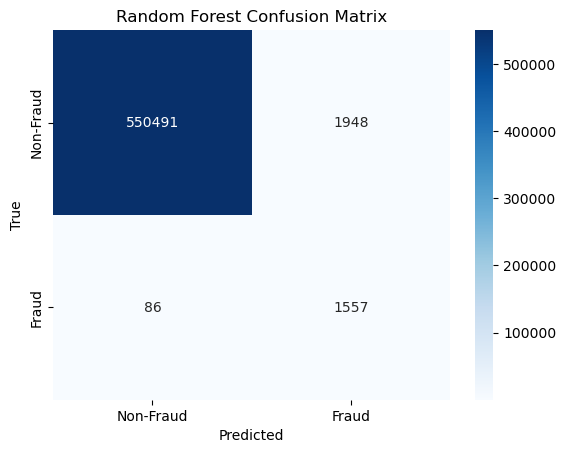

In [19]:
y_pred = best_rf_model.predict(X_test)
predicted_probabilities = best_rf_model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

### XGBoost

In [20]:
xgb_model = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1]
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

random_search_xgb.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gr...
                                        'lambda': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 250, 300,
                                                         350],
                                        'scale_pos_weight': [1, 5, 10, 15],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [21]:
best_xgb_params = random_search_xgb.best_params_
best_xgb_model = xgb.XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train_under_sampled, y_train_under_sampled)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250, ...)

In [22]:
print(best_xgb_params)

{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 0.9, 'alpha': 0.1}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.57      0.96      0.72      1643

    accuracy                           1.00    554082
   macro avg       0.79      0.98      0.86    554082
weighted avg       1.00      1.00      1.00    554082

[[551267   1172]
 [    71   1572]]


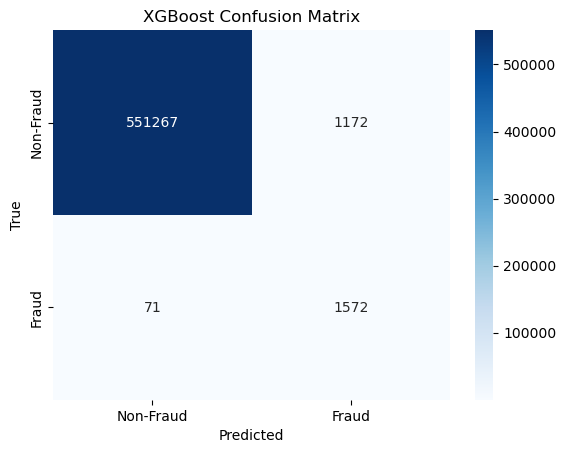

In [23]:
y_pred = best_xgb_model.predict(X_test)
predicted_probabilities = best_xgb_model.predict_proba(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, 'XGBoost Confusion Matrix')
plt.show()

In [24]:
best_xgb_model.save_model('../model/fraud_detection.model')

c:\Users\nokia\miniconda3\envs\scb\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [20:51:31] WARNING: D:\bld\xgboost-split_1748292846627\work\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


## Final Model Selection
### Model
**XGBoost Classifier**

- Performs well on tabular, imbalanced data

- Robust to outliers

- Fast training and inference time

- Compared to the RandomForestClassifier, achieves better recall and precision.

**Hyperparameter Tuning**

Generated an arbritary parameter grid and utilized the RandomSearchCV with to explore different combinations of hyperparameter. The best set of parameter that was found is:

{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 0.9, 'alpha': 0.1}

**Evaluation Metrics**
The following metrics were used to evaluate model performance:

ROG-AUC: Used in cross-validation to find the best hyperparameter for the model \
Recall:	Critical to catch as many frauds as possible \
Precision:	Ensures auditors don’t get too many false alarms \
F1-score:	Balances precision and recall, used to compare models during hyperparameter tuning \
Accuracy:	Reported but not relied on due to class imbalance 

Fraud Precision: 0.56 \
Fraud Recall:    0.97 \
Fraud F1-score:  0.71 \
Accuracy:        ~99.9% 

The high recall (97%) signifies the model's abilities to detect majority of frauds, with decent accuracy (56%). The accuracy is deemed acceptable as the transactions that were flagged will be further reviewed by a human auditor and not immediately blocked.
